In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cpu
Torchvision version: 0.24.0+cpu
CUDA is available: False


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

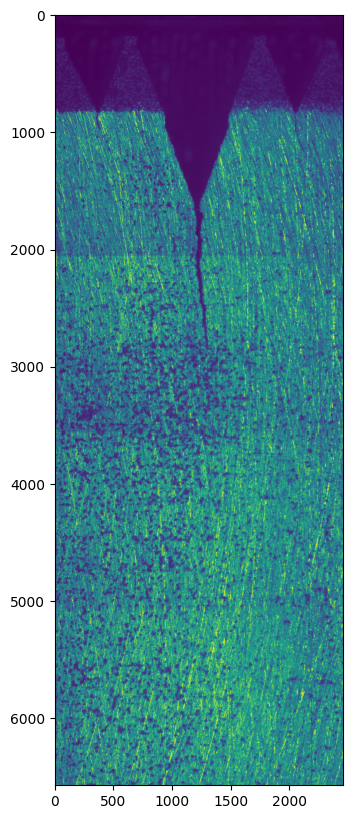

In [24]:
image = cv2.imread('../data/stitched_images/stitched_119.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# cv2.equalizeHist(image, image)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [25]:
from scipy.signal import find_peaks

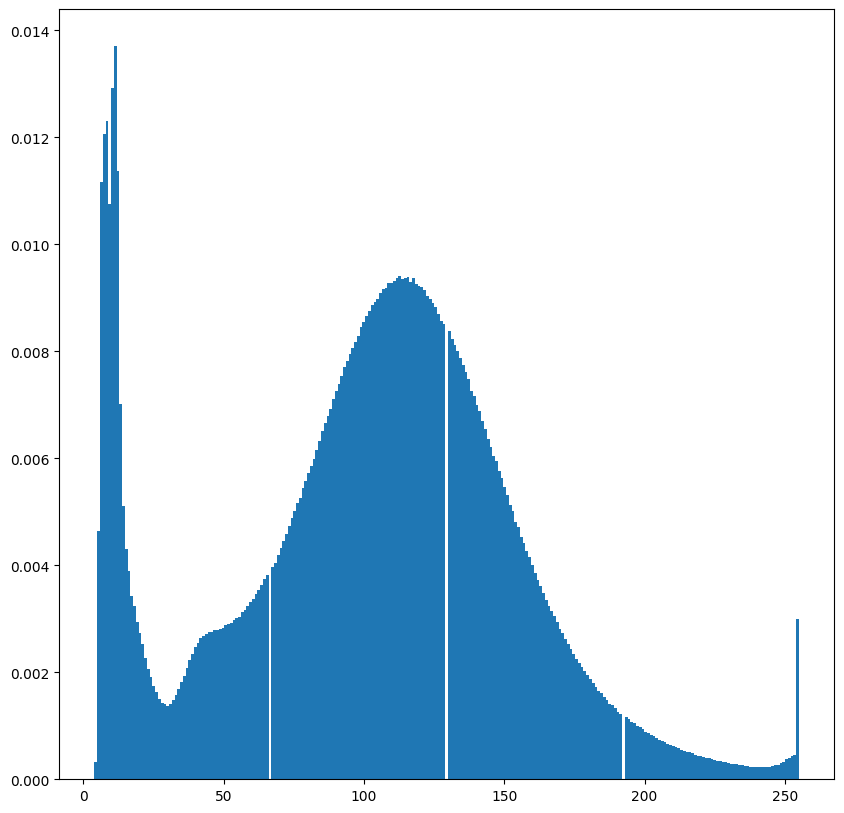

In [26]:
plt.figure(figsize=(10,10))
heights, xs, _ = plt.hist(image.flatten(), bins=255, density=True)
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture





array([[ 10.48233348],
       [112.7831718 ]])

In [27]:
def window_smooth(points, window_size : int = 10):
    max_idx = len(points)
    half_size = window_size // 2
    smoothed_points = []
    for i, val in enumerate(points):
        l = max(0, i - half_size)
        r = min(max_idx, i + half_size)
        smoothed_points.append(points[l:r].mean())
    return np.array(smoothed_points)

In [28]:
smoothed_heights = window_smooth(heights, window_size=40)

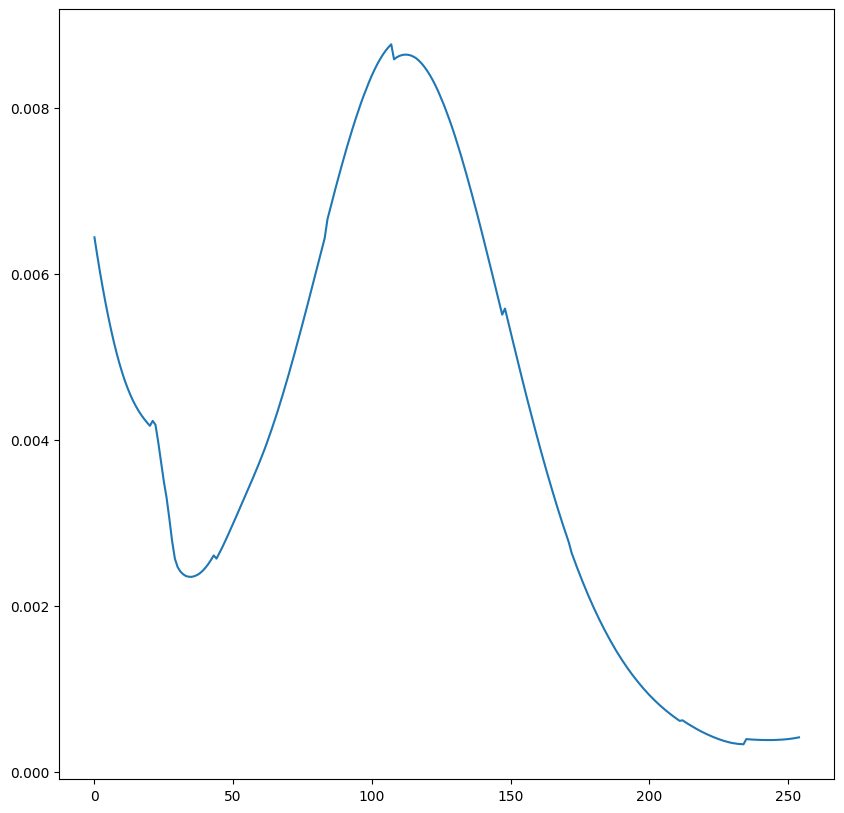

In [29]:
plt.figure(figsize=(10,10))
plt.plot(range(len(smoothed_heights)), smoothed_heights)
plt.show()

In [30]:
peaks, props = find_peaks(smoothed_heights, distance=30, prominence=1e-06)
assert len(peaks) >= 2, "Not enough peaks found"
order = np.argsort(props['prominences'])
top_peaks = peaks[order][-2:]
midpoint = min(top_peaks) + abs(top_peaks[0] - top_peaks[1]) / 2

In [31]:
top_peaks

array([148, 107])

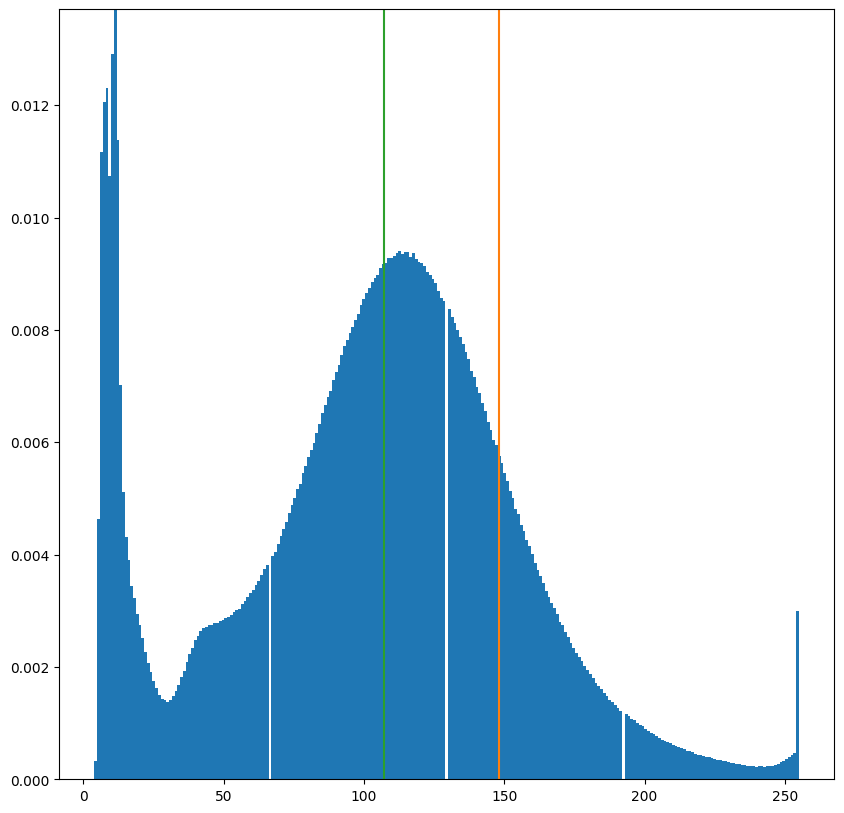

In [32]:
plt.figure(figsize=(10,10))
heights, xs, _ = plt.hist(image.flatten(), bins=255, density=True)
plt.plot([top_peaks, top_peaks], [0, 1])
plt.ylim(0, heights.max())
plt.show()

In [19]:
threshold = top_peaks[0] + (top_peaks[1] - top_peaks[0])/2

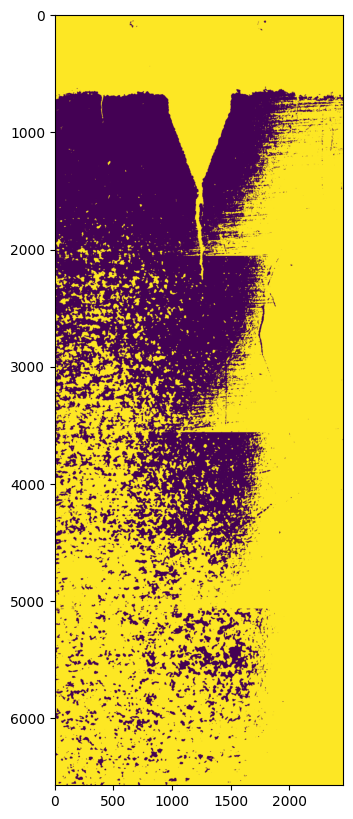

In [20]:
image = cv2.imread('../data/stitched_images/stitched_94.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = (image < threshold).astype(np.float32)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [14]:
contours, _ = cv2.findContours(image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
output = np.zeros_like(image)
cv2.drawContours(output, [largest_contour], -1, 255, thickness=cv2.FILLED)

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]],
      shape=(6574, 2464), dtype=float32)

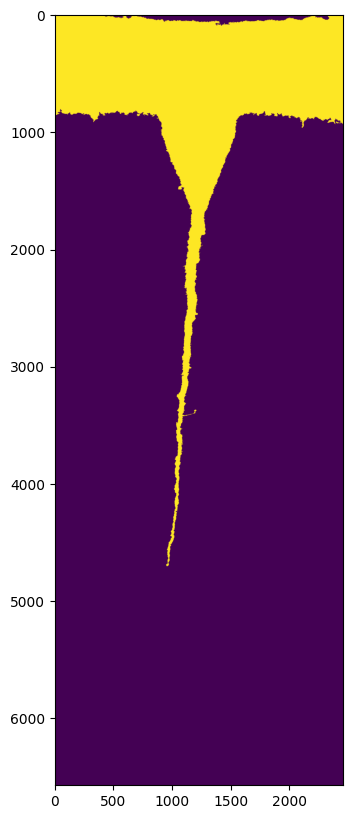

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(output)
# plt.axis('on')
plt.show()

In [17]:
from skimage import measure

props = measure.regionprops(output.astype(np.uint8))
centroid = props[0].centroid

In [18]:
centroid

(np.float64(701.2267387809461), np.float64(1227.0636988687238))

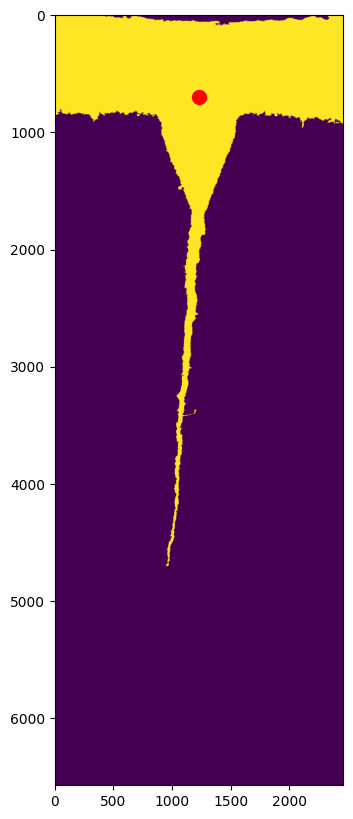

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.scatter(centroid[1], centroid[0], c='r', s=100)
# plt.axis('on')
plt.show()

In [63]:
image.shape

(6574, 2464, 3)

In [36]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=None)
predictor = SamPredictor(sam)

In [37]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [58]:
image = cv2.imread('../data/stitched_images/stitched_94.jpg', cv2.IMREAD_GRAYSCALE)
cv2.equalizeHist(image, image)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

predictor.set_image(image)

In [59]:
input_point = np.array([[1200, 1000]])
input_label = np.array([1])

In [67]:
# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=True,
# )

input_box = np.array([750, 0, 1500, 3000])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [68]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


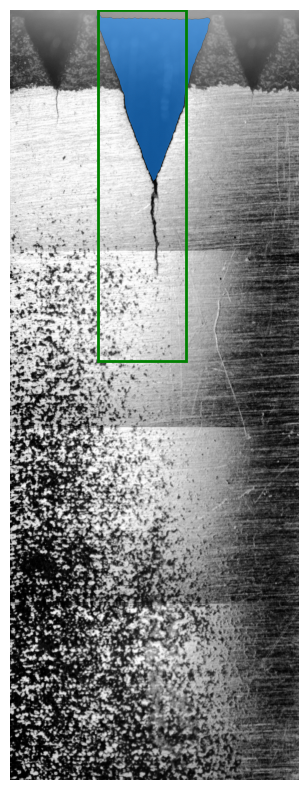

In [69]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

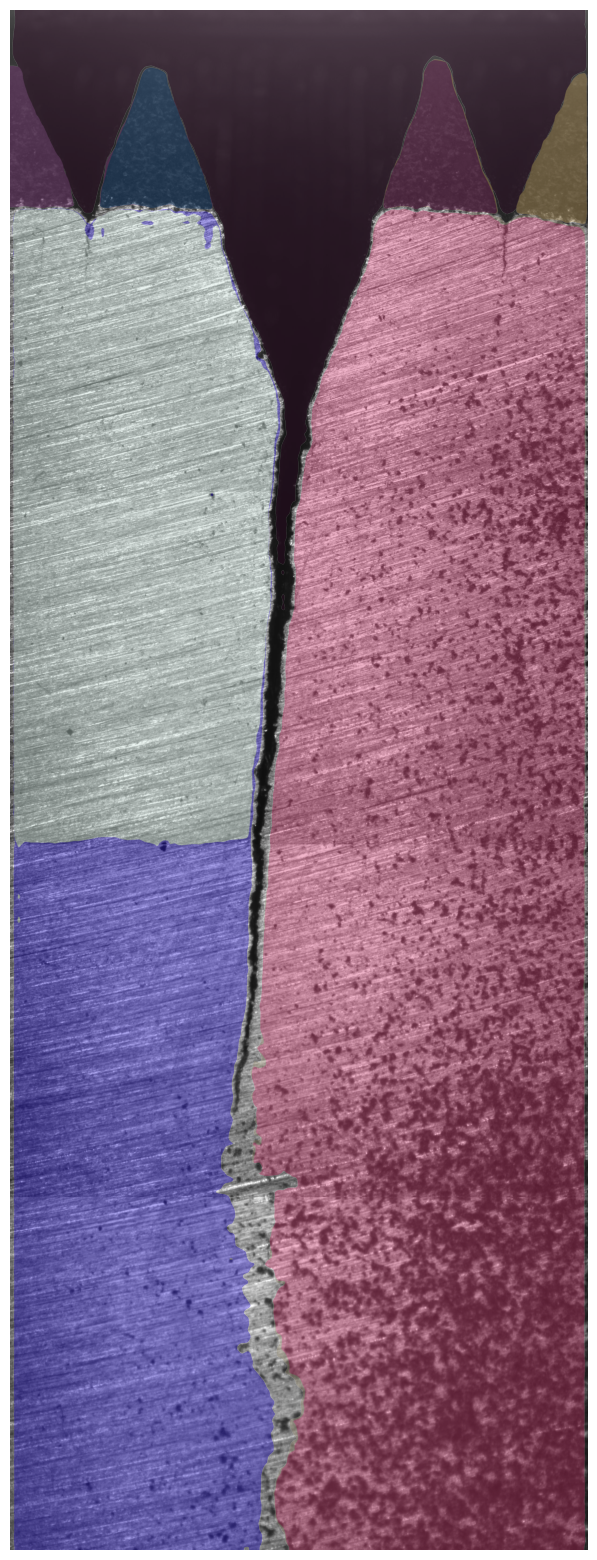

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 